In [3]:
!python -V
!pip install pyarrow

Python 3.10.9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 42.5 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [22]:
df = pd.read_parquet("../data/fhv_tripdata_2021-01.parquet")

In [24]:
old_df = len(df)

In [25]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [26]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime

In [27]:
df['duration'] = df.duration.dt.total_seconds()/60

In [28]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667
...,...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266,8.750000
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,,57.600000
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285,16.200000
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285,19.433333


In [29]:
df.duration.mean()

19.167224093791006

/tmp/ipykernel_1735/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

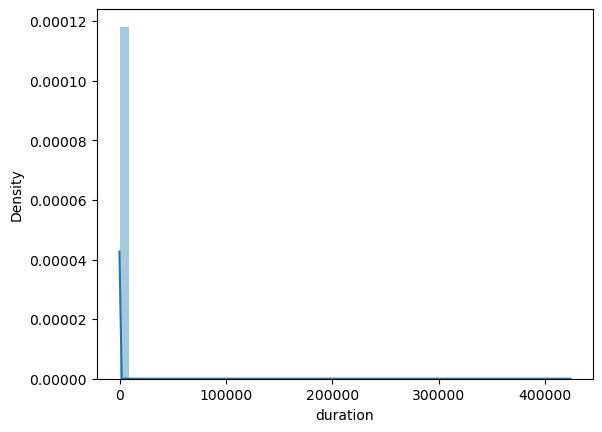

In [30]:
sns.distplot(df.duration)

In [31]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

In [32]:
df.isnull().sum()

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927008
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

In [33]:
df.isnull().mean()

dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.835273
DOlocationID              0.133270
SR_Flag                   1.000000
Affiliated_base_number    0.000697
duration                  0.000000
dtype: float64

In [40]:
categorical = ['PUlocationID','DOlocationID']
df[categorical] = df[categorical].fillna(-1).astype('int')

In [45]:
df[categorical] = df[categorical].astype('str')

In [46]:
train_dicts = df[categorical].to_dict(orient='records')

In [47]:
train_dicts[:10]

[{'PUlocationID': '-1', 'DOlocationID': '-1'},
 {'PUlocationID': '-1', 'DOlocationID': '-1'},
 {'PUlocationID': '-1', 'DOlocationID': '72'},
 {'PUlocationID': '-1', 'DOlocationID': '61'},
 {'PUlocationID': '-1', 'DOlocationID': '71'},
 {'PUlocationID': '-1', 'DOlocationID': '91'},
 {'PUlocationID': '-1', 'DOlocationID': '39'},
 {'PUlocationID': '-1', 'DOlocationID': '37'},
 {'PUlocationID': '-1', 'DOlocationID': '39'},
 {'PUlocationID': '-1', 'DOlocationID': '72'}]

In [48]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [49]:
X_train.shape

(1109826, 525)

In [51]:
y_train = df.duration.values

In [50]:
dv.feature_names_

['DOlocationID=-1',
 'DOlocationID=1',
 'DOlocationID=10',
 'DOlocationID=100',
 'DOlocationID=101',
 'DOlocationID=102',
 'DOlocationID=105',
 'DOlocationID=106',
 'DOlocationID=107',
 'DOlocationID=108',
 'DOlocationID=109',
 'DOlocationID=11',
 'DOlocationID=111',
 'DOlocationID=112',
 'DOlocationID=113',
 'DOlocationID=114',
 'DOlocationID=115',
 'DOlocationID=116',
 'DOlocationID=117',
 'DOlocationID=118',
 'DOlocationID=119',
 'DOlocationID=12',
 'DOlocationID=120',
 'DOlocationID=121',
 'DOlocationID=122',
 'DOlocationID=123',
 'DOlocationID=124',
 'DOlocationID=125',
 'DOlocationID=126',
 'DOlocationID=127',
 'DOlocationID=128',
 'DOlocationID=129',
 'DOlocationID=13',
 'DOlocationID=130',
 'DOlocationID=131',
 'DOlocationID=132',
 'DOlocationID=133',
 'DOlocationID=134',
 'DOlocationID=135',
 'DOlocationID=136',
 'DOlocationID=137',
 'DOlocationID=138',
 'DOlocationID=139',
 'DOlocationID=14',
 'DOlocationID=140',
 'DOlocationID=141',
 'DOlocationID=142',
 'DOlocationID=143',


In [52]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [53]:
y_pred = lr.predict(X_train)

In [55]:
mean_squared_error(y_train, y_pred, squared=False)

10.528519384876185

In [56]:
categorical = ['PUlocationID','DOlocationID']

def read_data(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df['duration'] = df.duration.dt.total_seconds()/60
    
    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()
    df[categorical] = df[categorical].fillna(-1).astype('int').astype('str')
    
    return df

In [57]:
df_val = read_data("../data/fhv_tripdata_2021-02.parquet")

In [58]:
df_val

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
1,B00021,2021-02-01 00:55:40,2021-02-01 01:06:20,173,82,None,B00021,10.666667
2,B00021,2021-02-01 00:14:03,2021-02-01 00:28:37,173,56,None,B00021,14.566667
3,B00021,2021-02-01 00:27:48,2021-02-01 00:35:45,82,129,None,B00021,7.950000
4,B00037,2021-02-01 00:12:50,2021-02-01 00:26:38,-1,225,None,B00037,13.800000
5,B00037,2021-02-01 00:00:37,2021-02-01 00:09:35,-1,61,None,B00037,8.966667
...,...,...,...,...,...,...,...,...
1037687,B03282,2021-02-28 23:01:16,2021-02-28 23:14:48,-1,31,None,B01717,13.533333
1037688,B03282,2021-02-28 23:36:10,2021-02-28 23:47:38,-1,169,None,B01717,11.466667
1037689,B03285,2021-02-28 23:18:36,2021-02-28 23:43:59,28,171,None,B03285,25.383333
1037690,B03285,2021-02-28 23:26:34,2021-02-28 23:44:37,16,252,None,B03285,18.050000


In [59]:
df_val.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                      object
DOlocationID                      object
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

In [60]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [62]:
X_val = dv.transform(val_dicts)

In [63]:
y_pred = lr.predict(X_val)

In [64]:
y_val = df_val.duration.values

In [65]:
mean_squared_error(y_val, y_pred, squared=False)

11.01428678629285